### Mathematical Simulation in Python, Billiard Dynamical Systems
### Summer Workshop in Mathematics, University of Brasilia
### Summer 2018, Session 1, Scott Cook

Goal: Write a simulation of "open billiard" system on pages 71-86 of https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/Random_Mechanical_Systems.pdf

Consider the standard Sinai billiard in dimension 2 consisting of a square with a circular "scatterer" removed from the center. http://www.dynamical-systems.org/sinai/

In 1963, Yakov Sinai proved that this system is ergodic (see http://people.cas.uab.edu/~simanyi/Sinai-Abel-Volume-Simanyi.pdf for a survey of this result and its extensions).  Thus, we have strong averaging properties.

We declare that part of the bottom side will be "open"; this means that the system starts with the particle entering throught this open side and ends when it returns.
- See p.80-82 for a proof that, with probability 1, the particle will eventually return to the open side using the Poincare Recurrence Theorem.  (Note that "trapped" trajectories can exist, but they form a set of measure zero.)
- Ergodicity of the closed billiard gives beautiful averaging properties to the open billiard, as discussed on p.83.
- We wish to simulate the time average side of these expressions and see that they do in fact equal the corresponding spatial average.

First, create objects for each wall and the particle.  Python (like many languages) allows you to define classes which are containers for attributes (information) and methods (functions).  Though we could do this simulation without writing classes, they will prove they useful as our code gets more complex.


As with many things in this minicourse, we try to write code that is clear, not clever.  There are better ways to do this, but I think this is easiest to learn.

Definitions:
- A class is a type of object.
- An instance is an object of that type.  Thus, we will make one class FlatWall and 4 instances of it.
- An attribute is a piece of data "bound" to an object
- A method is a funtion "bound" to an object.

In [1]:
import numpy as np   # implements fast matrix algebra
import matplotlib.pyplot as plt   # main visualization module

dim = 2
# cell size
x0 = 10
y0 = 10

# Define empty classes to start.  We will add stuff here later.
class Wall:
    pass

class FlatWall(Wall):
    pass

class CircleWall(Wall):
    pass

class Particles():
    pass

part = Particles()
part.num = 1
part.dim = dim
part.radius = np.full(part.num, 1.0) # an array of length part.num flled with the radius

wall = [FlatWall() for i in range(4)]

wall[0].base_point = [x0, 0]
wall[0].normal = [-1, 0]
wall[0].tangent = [0, y0]

wall[1].base_point = [0, y0]
wall[1].normal = [0, -1]
wall[1].tangent = [-x0,0]

wall[2].base_point = [-x0, 0]
wall[2].normal = [1, 0]
wall[2].tangent = [0, -y0]

wall[3].base_point = [0, -y0]
wall[3].normal = [0, 1]
wall[3].tangent = [x0, 0]


for w in wall:
    w.dim = part.dim
    w.wp_gap_min = part.radius  # part.pos is the particle center; must leave a gap so the entire particle fits

wall.append(CircleWall())
wall[4].base_point = [0,0]
wall[4].radius = 3
wall[4].wp_gap_min = part.radius + wall[4].radius


We'd like to plot the cell to makes sure it looks right.  We'll create a mesh of points for each wall using numpy linspace to get 100 evenly spaced numbers from -1 to 1.

In [2]:
s = np.linspace(-1,1,100)
print(s)
for w in wall[:4]:
    w.mesh = w.base_point + s*w.tangent
print(wall[0].mesh.shape)

[-1.         -0.97979798 -0.95959596 -0.93939394 -0.91919192 -0.8989899
 -0.87878788 -0.85858586 -0.83838384 -0.81818182 -0.7979798  -0.77777778
 -0.75757576 -0.73737374 -0.71717172 -0.6969697  -0.67676768 -0.65656566
 -0.63636364 -0.61616162 -0.5959596  -0.57575758 -0.55555556 -0.53535354
 -0.51515152 -0.49494949 -0.47474747 -0.45454545 -0.43434343 -0.41414141
 -0.39393939 -0.37373737 -0.35353535 -0.33333333 -0.31313131 -0.29292929
 -0.27272727 -0.25252525 -0.23232323 -0.21212121 -0.19191919 -0.17171717
 -0.15151515 -0.13131313 -0.11111111 -0.09090909 -0.07070707 -0.05050505
 -0.03030303 -0.01010101  0.01010101  0.03030303  0.05050505  0.07070707
  0.09090909  0.11111111  0.13131313  0.15151515  0.17171717  0.19191919
  0.21212121  0.23232323  0.25252525  0.27272727  0.29292929  0.31313131
  0.33333333  0.35353535  0.37373737  0.39393939  0.41414141  0.43434343
  0.45454545  0.47474747  0.49494949  0.51515152  0.53535354  0.55555556
  0.57575758  0.5959596   0.61616162  0.63636364  0.

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

That did not work for 2 reasons.  The error says the shapes are not compatible.  We'll fix that later, but there is another problem we must handle first: base_point and tangent are python lists.  They do not know matrix algebra.  See:

In [3]:
L = [1,2,3]
print(L)
print(5*L)

[1, 2, 3]
[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]


We wanted [5,10,15], but got 5 copies of L.  Numpy implements fast matrix algebra.  Not only is it convenient from a mathematical perspective, it is crucial for compuation speed.  Python is slow because it is as interpretted language.  Most numpy algorithms have been compiled into fast C (or C-like) code, making them much faster than a pure Python equivalent.  The single best way way to boost speed in Python is to vectorize your code with numpy.

Numpy uses the name "array" for all vectors and matrices.

In [4]:
L = np.asarray([1,2,3])
print(L)
print(5*L)

[1 2 3]
[ 5 10 15]


So, we will convert everything to numpy arrays. We will also force them to be floats to avoid problems.  Notice of the array above has dtype int.

In [5]:
L.dtype

dtype('int32')

This can occasionally cause problems - it can trigger integer division rather than float division.  If this happens, we will get 3 / 2 = 1 or 2 rather than 1.5.  This was a bigger problem in earlier versions of Python which has been largerly fixed now.  But I still prefer to add safeguards when convenient.

In [6]:
print(type(wall[0].base_point))
for w in wall[:4]:
    w.base_point = np.asarray(w.base_point).astype(float)
    w.normal = np.asarray(w.normal).astype(float)
    w.tangent = np.asarray(w.tangent).astype(float)
print(type(wall[0].base_point))

<class 'list'>
<class 'numpy.ndarray'>


Now, let's try the mesh again.

In [7]:
s = np.linspace(-1,1,100)
for w in wall[:4]:
    w.mesh = w.base_point + s*w.tangent
print(wall[0].mesh.shape)

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

We still have the shape issue.  We want is s*w.tangent to be a 100x2 array.  Numpy will help us via its broadcasting rules: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html
1. 

In [8]:
t = wall[0].tangent.copy()
try:
    m = s*t
    print(m.shape)
except:
    print('nope')

print(t.shape)
t = t[np.newaxis,:]
s = s[:,np.newaxis]
print(t.shape,s.shape)

try:
    m = s*t
    print(m.shape)
except:
    print('nope')


nope
(2,)
(1, 2) (100, 1)
(100, 2)


In [9]:
s = np.linspace(-1,1,100)
s = s[:,np.newaxis]
for w in wall[:4]:
    w.mesh = w.base_point + s*w.tangent[np.newaxis,:]
print(wall[0].mesh.shape)

(100, 2)


In [10]:
theta = np.linspace(0,2*np.pi,100)
w = wall[4]
w.mesh = np.array([np.cos(theta), np.sin(theta)]).T * w.radius + w.base_point

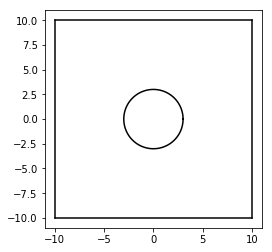

In [11]:
fig, ax = plt.subplots()
for w in wall:
    ax.plot(w.mesh[:,0], w.mesh[:,1], 'black')
ax.set_aspect('equal')
plt.show()

Here is another version that uses \* unpacking.  Observe that mesh has shape (pts,dim) so mesh.T has shape (dim,pts).  The * unpacks the first dimesion, giving dim vectors of length pts corresponding to each dimension.  

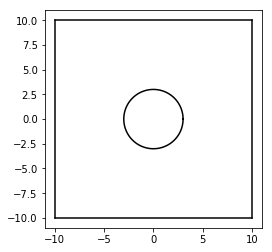

In [12]:
fig, ax = plt.subplots()
for w in wall:
    ax.plot(*(w.mesh.T), 'black')
ax.set_aspect('equal')
plt.show()

Here is a version that works in n dimensions if you define a list of n-1 tangent vectors.  It uses np.meshgrid which essentially gives the Cartesian product of n-1 copies of the parameter values.

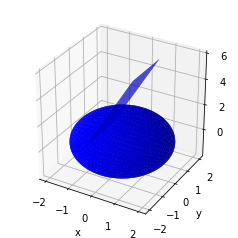

In [13]:
def flat_mesh(tangents):
    pts = 100
    N, D = tangents.shape
    grid = [np.linspace(-1, 1, pts) for n in range(N)]
    grid = np.meshgrid(*grid)
    grid = np.asarray(grid)
    mesh = grid.T.dot(tangents)
    return mesh

def sphere_mesh(dim, radius):
    pts = 100
    grid = [np.linspace(0, np.pi, pts) for d in range(dim-1)]
    grid[-1] *= 2
    grid = np.meshgrid(*grid)                           
    mesh = []
    for d in range(dim):
        w = radius * np.ones_like(grid[0])
        for j in range(d):
            w *= np.sin(grid[j])
        if d < dim-1:
            w *= np.cos(grid[d])
        mesh.append(w)
    return np.asarray(mesh).T

### 3D version
from mpl_toolkits.mplot3d import Axes3D
plane = flat_mesh(tangents=np.array([[1,0,3],[0,1,0]])) + np.array([0,0,3])
scatter = sphere_mesh(dim=3, radius=2)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(*(plane.T), color='b')
ax.plot_surface(*(scatter.T), color='b')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Good, now let's put a particle into the cell.  For simplicity:
- use only 1 particle
- pick initial positions and velocities explicitly ... we will pick randomly later

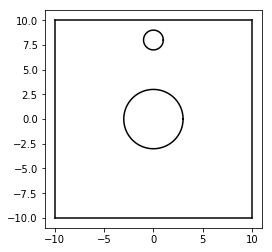

In [14]:
part.pos = np.array([[0,2*wall[4].wp_gap_min]])
part.vel = np.array([[0.0,-1.0]])
part.mesh = [sphere_mesh(dim=part.dim, radius=part.radius)]

fig, ax = plt.subplots()
for w in wall:
    ax.plot(*(w.mesh.T), 'black')
for p in range(part.num):
    ax.plot(*(part.mesh[p]+part.pos[0]).T, 'black')
ax.set_aspect('equal')
plt.show()

Steps
1. Compute time until collision with each wall
2. Find min
3. Move the particle
4. Resolve the collision

We must compute time until collision differently for flat walls and circle walls.  This is the right situation for class methods.  Let's refactor our code and add appropriate class methods.  Some key facts:
- part.pos are the *centers* of the particles; we must leave a gap for the entire particle
- the normal vector for a circle wall depends on the position; not true for a flat wall

For FlatWall, let $dx$ = part.pos - wall.base_point, $v$=vel, $g$ = wp_gap_min, and $n$=unit normal.  Then distance to wall = orthogonal projection of (dx+tv) onto n.  We solve for collision time via:

$$g=(\vec{dx}+t\vec{v}) \cdot \vec{n} = \vec{dx}\cdot\vec{n} + t(\vec{v}\cdot\vec{n})$$
$$t = \frac{g-\vec{dx}\cdot\vec{n}}{(\vec{v}\cdot\vec{n})}$$

In [15]:
# flat wall
# computes time to next collision with each particle via proj (x+vt) onto normal = wp_gap_main
def get_wp_col_time(w):
    nu = w.normal
    dx = part.pos - w.base_point
    c = w.wp_gap_min - dx.dot(nu)
    b = part.vel.dot(nu)
    t = c / b
    return t
dts = [get_wp_col_time(w) for w in wall[:4]]
print(dts)


[array([-inf]), array([-1.]), array([-inf]), array([ 17.])]


C:\ProgramData\Anaconda3_6\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


This is good except
1. it divides by 0 if the particle moves parallel to a wall
2. it can return negative times

In [16]:
abs_tol = 1e-4
def get_wp_col_time(w):
    t = np.full(part.num, np.inf)  # default in np.inf
    nu = w.normal
    dx = part.pos - w.base_point
    c = w.wp_gap_min - dx.dot(nu)
    b = part.vel.dot(nu)
    idx = np.abs(b) >= abs_tol  # prevents divide by zero
    t[idx] = c[idx] / b[idx]
    t[t<0] = np.inf  #np.inf for negative times
    return t
dts = [get_wp_col_time(w) for w in wall[:4]]
print(dts)

[array([ inf]), array([ inf]), array([ inf]), array([ 17.])]


For time to collision with the circular scatter, we recall that wp_min_gap was defined as the particle radius + scatterer radius.  Thus:
$$\vec{dx}+t\vec{v} \cdot \vec{dx}+t\vec{v} = g^2$$
We get a quadratic equation:
$$(\vec{v} \cdot \vec{v}) t^2 + 2(\vec{dx} \cdot \vec{v})t + (\vec{dx} \cdot \vec{dx}-g^2)=0$$
We want the smallest positive solution.  We break this into 2 functions:

In [17]:
# Solves for positive solutions to at^2+bt+c=0, guarding against degenerate cases.
# Like the flat wall, we write vectorized code that will efficiently handle many particle systems later.
# a,b,c can be arrays with many entries - they must have the same shape.  Each entry treated as an
# independent quadratic equation.

def solve_quadratic(a, b, c):
    small = np.full_like(a, np.inf)  
    d = b**2 - 4*a*c  #discriminant
    lin = (abs(a) < abs_tol) & (abs(b) >= abs_tol)  #linear 
    quad = (abs(a) >= abs_tol) & (d >= abs_tol)  #quadratic
    
    small[lin] = -1 * c[lin] / b[lin]
    big = small.copy()
    
    d[quad] = np.sqrt(d[quad])
    small[quad] = (-b[quad] - d[quad]) / (2*a[quad])
    big[quad] = (-b[quad] + d[quad]) / (2*a[quad])
    swap = (b >= abs_tol)  # We want the solutions ordered (small, big), so we swap where needed
    small[swap], big[swap] = big[swap], small[swap]
    
    small[small<0] = np.inf
    big[big<0] = np.inf
    return small, big

def get_wp_col_time(w):
    dx = part.pos - w.base_point
    dv = part.vel
    a =   (dv*dv).sum(axis=-1)
    b = 2*(dv*dx).sum(axis=-1)
    c =   (dx*dx).sum(axis=-1) - w.wp_gap_min**2
    t_small, t_big = solve_quadratic(a, b, c)
    t = np.fmin(t_small, t_big)
    return t
dts = [get_wp_col_time(w) for w in wall]

Now, this still has one issue.  A particle *leaving* a wall after a collision will show $dt=0$ to collision during the next step.  As a result, the program can get stuck.  We will implement a mask to protect again this later.

Now, we find the minimum positive time dt and advance the particle by dt * vel.  Then we resolve the collision.  For specular collision, the normal component of the velocity is reversed, while the tangential component does not change.

In [ ]:
def wp_specular_law(w, part, p):
    nu = w.normal(part.pos[p])
    part.vel[p] -= 2 * (part.vel[p].dot(nu)) * nu

We now have all the pieces we need.  Let us put them all together, making use of the class methods for organization.

Comments
- self refers to the object the method is bound to.  Many variables used above become self in the refactored code below.
- Normal vector for a circle wall depends on the position, but not for a flat wall.  For consistency, every wall class will provide .normal(pos) method, even though flat walls will not use the pos argument.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

abs_tol = 1e-4

class Wall:
    def wp_specular_law(self, part, p):
        nu = self.normal(part.pos[p])
        part.vel[p] -= 2 * part.vel[p].dot(nu) * nu

    def resolve_collision(self, part, p):
        self.wp_specular_law(part, p)
        
class FlatWall(Wall):
    def get_mesh(self):
        self.mesh = flat_mesh(self.tangents) + self.base_point
        
    def normal(self, pos):  # normal does not depend on collision point
        return self.normal_static

    def get_wp_col_time(self, mask=None):
        t = np.full(part.num, np.inf)  # default in np.inf
        nu = self.normal_static
        dx = part.pos - self.base_point
        c = self.wp_gap_min - dx.dot(nu)
        b = part.vel.dot(nu)
        idx = np.abs(b) >= abs_tol  # prevents divide by zero
        t[idx] = c[idx] / b[idx]
        if mask is not None:
            t[mask] = np.inf
        t[t<0] = np.inf  #np.inf for negative times
        return t
    
class SphereWall(Wall):
    def get_mesh(self):
        self.mesh = sphere_mesh(self.dim, self.radius) + self.base_point

    def normal(self, pos): # normal depends on collision point
        dx = pos - self.base_point
        return make_unit(dx)  # see below for make_unit

    def get_wp_col_time(self, mask=None):
        dx = part.pos - self.base_point
        dv = part.vel
        a =   (dv*dv).sum(axis=-1)
        b = 2*(dv*dx).sum(axis=-1)
        c =   (dx*dx).sum(axis=-1) - self.wp_gap_min**2
        t_small, t_big = solve_quadratic(a, b, c, mask)
        t = np.fmin(t_small, t_big)
        return t
        
class Particles():
    def record_state(self):
        self.t_hist.append(self.t)
        self.pos_hist.append(self.pos.copy())        
        self.vel_hist.append(self.vel.copy())

    def get_KE(self):
        KE = self.mass * np.sum(self.vel**2, axis=-1)
        return np.sum(KE) / 2
        
        
def make_unit(A, axis=-1):
    # Normalizes along given axis.  This means that Thus, np.sum(A**2, axis) gives a matrix of all 1's.
    #In other words, if you pick values for all indices except axis and sum the squares, you get 1.  
    A = np.asarray(A, dtype=float)
    M = np.linalg.norm(A, axis=axis, keepdims=True)
    return A / M

def solve_quadratic(a, b, c, mask=None):
    small = np.full_like(a, np.inf)  
    d = b**2 - 4*a*c  #discriminant
    lin = (abs(a) < abs_tol) & (abs(b) >= abs_tol)  #linear 
    quad = (abs(a) >= abs_tol) & (d >= abs_tol)  #quadratic
    
    small[lin] = -1 * c[lin] / b[lin]
    big = small.copy()
    
    d[quad] = np.sqrt(d[quad])
    small[quad] = (-b[quad] - d[quad]) / (2*a[quad])
    big[quad] = (-b[quad] + d[quad]) / (2*a[quad])
    swap = (b >= abs_tol)  # We want the solutions ordered (small, big), so we swap where needed
    small[swap], big[swap] = big[swap], small[swap]
    if mask is not None:
        small[mask] = np.inf
        big[mask] = np.inf
    small[small<0] = np.inf
    big[big<0] = np.inf
    return small, big

def flat_mesh(tangents):
    pts = 100
    N, D = tangents.shape
    grid = [np.linspace(-1, 1, pts) for n in range(N)]
    grid = np.meshgrid(*grid)
    grid = np.asarray(grid)
    mesh = grid.T.dot(tangents)
    return mesh

def sphere_mesh(dim, radius):
    pts = 100
    grid = [np.linspace(0, np.pi, pts) for d in range(dim-1)]
    grid[-1] *= 2
    grid = np.meshgrid(*grid)                           
    mesh = []
    for d in range(dim):
        w = radius * np.ones_like(grid[0])
        for j in range(d):
            w *= np.sin(grid[j])
        if d < dim-1:
            w *= np.cos(grid[d])
        mesh.append(w)
    return np.asarray(mesh).T

def draw_state():
    pos = np.asarray(part.pos_hist)
    fig, ax = plt.subplots()
    for w in wall:
        ax.plot(*(w.mesh.T), 'black')
    for p in range(part.num):
        ax.plot(pos[:,p,0], pos[:,p,1])#, color=clr[p])
        ax.plot(*(part.mesh[p]+pos[-1]).T, 'black')
    ax.set_aspect('equal')
    plt.show()

dim = 2
# cell size
x0 = 10
y0 = 10

wall = [FlatWall() for i in range(4)]

wall[0].base_point = [x0, 0]
wall[0].normal_static = [-1, 0]
wall[0].tangents = [[0, y0]]

wall[1].base_point = [0, y0]
wall[1].normal_static = [0, -1]
wall[1].tangents = [[-x0,0]]

wall[2].base_point = [-x0, 0]
wall[2].normal_static = [1, 0]
wall[2].tangents = [[0, -y0]]

wall[3].base_point = [0, -y0]
wall[3].normal_static = [0, 1]
wall[3].tangents = [[x0, 0]]

wall.append(SphereWall())
wall[4].dim = dim
wall[4].base_point = np.asarray([0,0])
wall[4].radius = 3

part = Particles()
part.num = 1
part.dim = dim
part.radius = np.full(part.num, 1.0) # an array of length part.num flled with the radius
part.mass = np.full(part.num, 2.0) # an array of length part.num flled with the mass
part.cell_size = [[-x0,x0],[-y0,y0]]

for w in wall[:4]:
    w.dim = dim
    w.base_point = np.asarray(w.base_point).astype(float)
    w.normal_static = np.asarray(w.normal_static).astype(float)
    w.tangents = np.asarray(w.tangents).astype(float)
    w.wp_gap_min = part.radius
    w.get_mesh()

wall[4].dim = dim
wall[4].wp_gap_min = wall[4].radius + part.radius
wall[4].get_mesh()

def init(wall, part):
    part.mesh = [sphere_mesh(dim=part.dim, radius=part.radius)]
    part.t = 0.0
    part.t_hist = []
    part.pos_hist = []
    part.vel_hist = []
    part.col_hist = []
    
    part.col = {}
    part.KE_init = part.get_KE().sum()
    part.wp_dt = np.full([len(wall), part.num], np.inf)
    part.wp_mask = np.zeros_like(part.wp_dt).astype(bool)
    part.record_state()

def next_state(wall, part):
    for (i,w) in enumerate(wall):
        part.wp_dt[i] = w.get_wp_col_time(part.wp_mask[i])
    part.dt = np.min(part.wp_dt)

    part.t += part.dt
    part.pos += part.vel * part.dt

    part.wp_mask = (part.wp_dt - part.dt) < abs_tol
    w, p = np.nonzero(part.wp_mask)
    
    # later, we will need to protect against "complex collisions" where a particle make 
    # multiple simultaneous collisions.  For simplicity of the code, we'll ignore this
    # for now, knowing that we may get unexpected behavior if this occurs.
    w, p = w[0], p[0]
    part.col = {'w':w, 'p':p}
    wall[w].resolve_collision(part, p)
    part.record_state()

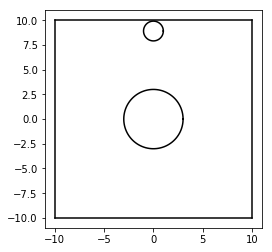

In [14]:
part.cell_size = [x0-part.radius[0], y0-part.radius[0]]
part.pos = np.array([[0,0.99*part.cell_size[1]]])
part.vel = np.array([[0.1,-1.0]])
init(wall, part)
draw_state()

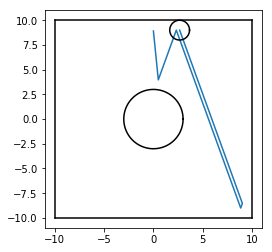

In [19]:
next_state(wall, part)
draw_state()

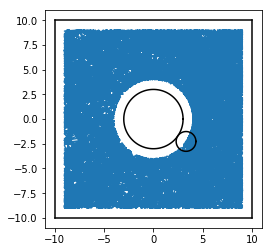

56 escapes / 1000 collisions = 0.0560
6.00 hole length / 97.13 total boundary length = 0.0618


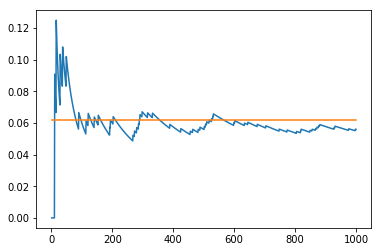

In [38]:
part.cell_size = [x0-part.radius[0], y0-part.radius[0]]
part.pos = np.array([[0,0.99*part.cell_size[1]]])
part.vel = np.array([[0.9,-1.0]])

hole_radius = 3
if hole_radius > part.cell_size[0]:
    raise Exception('Hole is bigger than its wall')
part.escapes = [0]
max_steps = 1000


init(wall, part)
# draw_state()

for step in range(max_steps):
    next_state(wall, part)
    #draw_state()
    part.escapes.append(part.escapes[-1])
    if np.abs(part.pos[0][0]) < hole_radius:
        if np.abs(part.pos[0][1] - y0 + part.radius) < abs_tol:
            part.escapes[-1] += 1
draw_state()

L = np.arange(1, len(part.escapes))
escape_prop = part.escapes[1:] / L

hole_length = 2*hole_radius
boundary_length = 4*part.cell_size[0] + 4*part.cell_size[1] + 2 * np.pi * wall[4].wp_gap_min[0]
hole_prop = hole_length / boundary_length

print('{} escapes / {} collisions = {:.4f}'.format(part.escapes[-1], L[-1], escape_prop[-1]))
print('{:.2f} hole length / {:.2f} total boundary length = {:.4f}'.format(hole_length, boundary_length, hole_prop))
plt.plot(L, escape_prop)
y = np.full_like(escape_prop, hole_prop)
plt.plot(L, y)
plt.show()